<a href="https://colab.research.google.com/github/adityapribadi3/Privacy-Machine-Learning/blob/main/MEAP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: Fully Connected Networks

The goal in this chapter is to:


* Implement a training loop in Pytorch
* Changing loss function for regression and classification problems
* Implementing and training a fully connected network
* Training faster using smaller batches of data



## Implementing training loop


We will first learn how to set up this optimization approach to learn. This process often known as __training loop__.

We will start with two basic algorithms (linear and logistic regression) to learn how training loop work for classification and regression.

The vector of weights that makes a logistic/linear regression is also called a linear layer or a fully connected layer.

This means both can be described as a “single layer” model in PyTorch. The model can be seen below.

<img src="https://drive.google.com/uc?export=view&id=1tZoGHyTslqFbx1oISuFzesOYFo_Yri40" alt="drawing" width="200"/>

## Neural network as optimization

In the last chapter, we defined a loss function to minimize and used the .backward() function to compute gradients, which told us how to alter the parameters to minimize the function.

If we make the input to the loss function a neural network, then we can use this exact same approach to train a neural network. 

This creates a process called a training loop with three major components: 
1. the training data (with correct answers),
2. the model and loss function, and
3. the update via gradients. 

These three components are outlined in Figure below.

<img src="https://drive.google.com/uc?export=view&id=1gyZQocsObBYFzylRBVroLzW2nrYLeRq4" alt="drawing" width="600"/>

Assume that $x$ is our input feature and $f()$ is our network model. The label associated with $x$ is $y$.

Our model takes in $x$ producing $\hat{y}$, which can be written as:

$$\hat{y}=f(x)$$


Then, our model also need a parameter to alter it's prediction and reduce the loss function. This parameter will be denoted as $\Theta$

We can also explicitly say that a function is dependent to a parameter as shown below:

$$\hat{y}=f_{\Theta}(x)$$

Next, we also need to define a loss function to quantifies how badly our model at predicting the ground truth. If $y$ is the desired label and $\hat{y}$ is our prediction, the loss function can be denoted as $$l(y,\hat{y})$$

Now let's say that we have a training set with $N$ samples. Our loss function can be stated as  $$\min_{\Theta} \sum_{i=1}^{N} l(f_{\Theta}(x_{i}), y_{i})$$

Which can be read as below:

<img src="https://drive.google.com/uc?export=view&id=1Lcf-mOJ-3EsF9UZa-gOAbHZBF98gQsZe" alt="drawing" width="600"/>

If we implement it, the code would look like below:


In [ ]:
def F(X, y, f, theta):
    N = len(X)
    total_loss =0
    for i in range(N):
        total_loss += loss(f(X[i,:], theta), y[i])
    return total_loss

After calculating the loss, the next question is how to adjust the $\Theta$?

Let's say that $\Theta_{k}$ is the current state of our model. We want to define  $\Theta_{k+1}$, that hopefully reduces our model's loss. To solve this we can use the mathematical model below. 

$$\Theta_{k+1}= \Theta_{k}-\eta \cdot \frac{1}{N} \sum_{i=1}^N \nabla_{\Theta_{k}}l(f_{\Theta}(x_{i}), y_{i})$$

The equation above is known as "gradient decent".
The nabla $\nabla$ in the equation is the gradient we use to refer to the
derivative with respect to every parameter.

If we want to alter a subset $z$ of the parameters, we would write it as $\nabla_z$.

This means $\nabla$ is going to be a tensor, with one value for every parameter.


## Linear Regression

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from idlmam import *

### The training loop

Suppose that we have loss function ($l(\cdot, \cdot)$) that takes a prediction ($\hat{y}$) and a target ($y$), returning a single score which defines how well a model ($f(\cdot)$) has done.

We will need an iterator that loads the training data for us to train on. This **training_loader** will gives us pairs of inputs with their associated labels for training.

<img src="https://drive.google.com/uc?export=view&id=1Ij-Ln_SXIK2e4y_klMzbvG8mvCQV_Mqe" alt="drawing" width="600"/>

* Yellow : The "prep" section shows the object creation that needs to be done before the training can start.
* Red : Indicate the start/repetition of the "loop", which provides new data for us to train on.
* Blue : Computes the prediction and loss for the model with its current $\Theta$
* Green : Taking loss, computing the gradients, and updates $\Theta$

This concept is applied on the code below

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import time

In [ ]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"):
    # Yellow steps
    # Defining optimizer, which is SGD over the parameter \theta
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # Place the model to the correct compute resource (CPU or GPU)
    model.to(device)

    # Red steps
    # Loop through all the data (batches) multiple times(epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # Put model in training mode
        model = model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            # Move the batch of data to the device we are using.
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            # PyTorch store gradients in mutable data structure
            # Hence, we need to clean it manually
            optimizer.zero_grad()

            # Blue steps
            # Compute prediction
            y_hat = model(inputs)

            # Compute loss
            loss = loss_func(y_hat, labels)

            # Green steps
            # Compute gradient
            loss.backward()

            # Update Parameters
            optimizer.step()

            running_loss += loss.item()


Now, we have a code to train the network. Now, let's try to learn simple Linear Regression problem and apply it to a real world scenario that can be solve by a linear regression (e.g., predicting miles per gallon of a car based on it's features, such as weight in pounds, engine size, year produced).

First, let's create a synthetic regression problem which has a linear and non-linear component.

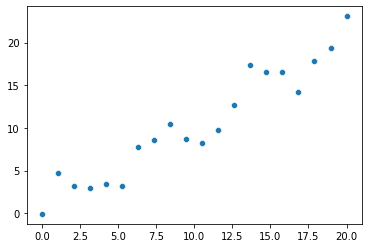

In [ ]:
# Create a 1-dimensional input
X = np.linspace(0,20, num=20)
# Create an output
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

Below we create a simple dataset object that knows we have a 1-dimensional problem. The training data will be shaped as $(n, 1)$ matrix, where $n$ is the
number of data points we have. The labels $(y)$ will take a similar form.

In [ ]:
class Simple1DRegressionDataset(Dataset):

    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        # data = X.reshape(-1,1)
        # print(data.shape)
        # print(X.shape)
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

### Defining the model, loss function, and learning

In [ ]:
in_features =1
out_features =1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device("cuda")
train_simple_network(model, loss_func, training_loader, device=device)

In [ ]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), device=device,
    dtype=torch.float32)).cpu().numpy()

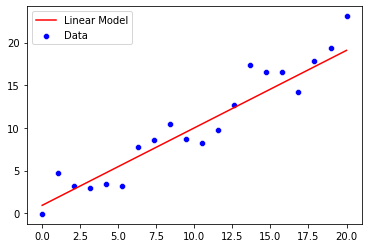

In [ ]:
#The data
sns.scatterplot(x=X, y=y, color='blue', label='Data') 

#What our model learned
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') 